In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pathlib
from io import BytesIO
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline

In [28]:
from PIL import Image
from ikapati.visualization import visualize as vz
from ikapati.data import io

In [11]:
model_dir_path = "../models/7feacba0-2be0-4761-ba49-854067714f3b/"
model_dir = pathlib.Path(model_dir_path)
training_csv_filename = model_dir.joinpath("training.csv")
training_csv = pd.read_csv(training_csv_filename)
data_dir = pathlib.Path("../data/processed")
train_dir = data_dir.joinpath("all")
sub_dirs = list(filter(lambda x: x.is_dir(), model_dir.iterdir()))

In [12]:
training_csv

start_time             end_time activation  \
0  2020-02-08__02_1926  2020-02-08__03_2838       relu   
1  2020-02-08__08_2457  2020-02-08__09_3845       relu   
2  2020-02-08__19_3845  2020-02-08__19_5751       relu   
3  2020-02-08__20_2543  2020-02-08__21_3708       relu   
4  2020-02-08__21_5614  2020-02-08__23_0917       relu   
5  2020-02-08__23_4632  2020-02-09__01_0035       relu   
6  2020-02-09__01_1232  2020-02-09__02_2213       relu   
7  2020-02-09__02_2409  2020-02-09__03_3321       relu   
8  2020-02-09__04_1552  2020-02-09__04_3637       relu   

                                      model_dir_path  learning_rate  dropout  \
0  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.050      NaN   
1  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.050      NaN   
2  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   
3  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   
4  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   
5  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   
6  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   
7  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.050      NaN   
8  models/7feacba0-2be0-4761-ba49-854067714f3b/20...          0.001      NaN   

   epochs  batch_size  
0      20         128  
1      20          64  
2      20         100  
3      20         100  
4      20         100  
5      20          64  
6      20         128  
7      20         128  
8      20         128

In [14]:
vz.save_metrics_plots_for_training(training_csv_filename)

<Figure size 432x288 with 0 Axes>

In [6]:
def make_paths(paths):
    return list(map(lambda p: pathlib.Path("..", p), paths))

In [7]:
model_dir_paths = make_paths(training_logs["model_dir_path"].values)

In [8]:
def is_checkpoint(item):
    return item.stem.isnumeric()

def get_checkpoints(directory):
    return list(filter(is_checkpoint, list(directory.iterdir())))

def get_best_checkpoint(checkpoints):
    checkpoint_numbers = list(map(lambda x: int(x.stem), checkpoints))
    return np.argmax(checkpoint_numbers) if checkpoint_numbers else None

def get_best_checkpoint_in_directory(directory):
    checkpoints = get_checkpoints(directory)
    best_checkpoint = get_best_checkpoint(checkpoints)
    return checkpoints[best_checkpoint] if best_checkpoint else None

def get_best_checkpoint_files(sub_dirs):
    checkpoint_paths = []
    for sub_dir in sub_dirs:
        items = list(sub_dir.iterdir())
        best_checkpoint = get_best_checkpoint_in_directory(sub_dir)
        if best_checkpoint:
            checkpoint_paths.append(best_checkpoint)
    return checkpoint_paths

In [9]:
def evaluate_model(model_file_path):
    metadata_file_path = model_file_path.parent.joinpath("metadata.json")
    metadata = io.read_metadata(str(metadata_file_path))
    batch_size = metadata["arguments"]["batch_size"]
    test_data_path = train_dir.joinpath("test.tfrecord")
    test_dataset = io.read_dataset(str(test_data_path), batch_size, metadata["dataset"]["num_classes"])
    steps = metadata["dataset"]["file_counts"]["test"] // batch_size
    model = tf.keras.models.load_model(str(model_file_path))
    results = model.evaluate(test_dataset, steps=steps)
    print(results)
    return model, results

In [ ]:
results = []

for model_dir_path in model_dir_paths:
    print(str(model_dir_path))
    model_file_path = get_best_checkpoint_in_directory(model_dir_path)
    if not model_file_path:
        print(f"{str(model_dir_path)} : No model found, skipping.")
        continue
    model, result = evaluate_model(model_file_path)
    results.append([str(model_dir_path), result])
    model = None

../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__02_1926
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__02_1926 : No model found, skipping.
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__08_2457
165/165 [==============================] - 41s 248ms/step - loss: 0.4513 - accuracy: 0.8848
[0.4513429146824461, 0.88475376]
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__19_3845
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__19_3845 : No model found, skipping.
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__20_2543
105/105 [==============================] - 31s 299ms/step - loss: 0.1010 - accuracy: 0.9705
[0.10097126775376854, 0.9704762]
../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__21_5614


In [18]:
model = None

In [33]:
model_dir_paths

[PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__02_1926'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__08_2457'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__19_3845'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__20_2543'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__21_5614'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__23_4632'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-09__01_1232'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-09__02_2409'),
 PosixPath('../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-09__04_1552')]

In [6]:
evaluation = pd.read_csv("../reports/evaluation.csv")

In [8]:
evaluation.iloc[3]

id                              7feacba0-2be0-4761-ba49-854067714f3b
model_file_path    models/7feacba0-2be0-4761-ba49-854067714f3b/20...
batch_size                                                        64
epochs                                                            20
monitor                                                     val_loss
activation                                                      relu
early_stopping                                                 False
architecture                                             inceptionv3
dropout                                                          NaN
learning_rate                                                  0.001
loss                                                       0.0893377
accuracy                                                    0.973485
Name: 3, dtype: object

In [9]:
image_filename = "../Potato-leaf-blight.jpg"

In [10]:
from PIL import Image
im = Image.open(image_filename)

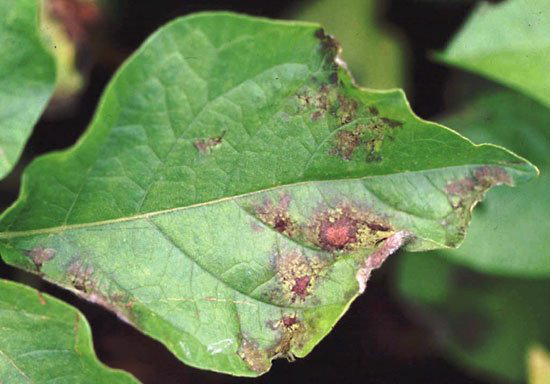

In [11]:
im

In [13]:
resized_im = im.resize((256,256))

In [14]:
resized_im.save("Potato-leaf-blight.jpg")

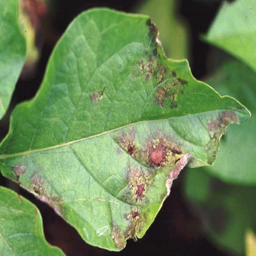

In [15]:
resized_im

In [16]:
! curl -O https://extension.umd.edu/sites/extension.umd.edu/files/resize/_images/programs/grow_it_eat_it/diseases/Septoria/septoria_tomato_l1-250x188.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15990  100 15990    0     0  31414      0 --:--:-- --:--:-- --:--:-- 31352


In [17]:
! ls

1.0-agj-data-exploration.ipynb	   4.1-agj-evaluate-Potato.ipynb
2.0-agj-image-preprocessing.ipynb  4.1-agj-evaluate-Tomato.ipynb
2.1-agj-image-preprocessing.ipynb  4.2-agj-evaluate-Apple.ipynb
3.0-agj-training.ipynb		   4.2-agj-evaluate-Tomato.ipynb
3.1-agj-training-batch.ipynb	   5.0-agj-evaluation-all.ipynb
4.0-agj-evaluation.ipynb	   Potato-leaf-blight.jpg
4.1-agj-evaluate-Apple.ipynb	   septoria_tomato_l1-250x188.jpg
4.1-agj-evaluate-Corn.ipynb


In [18]:
im = Image.open("septoria_tomato_l1-250x188.jpg")

In [19]:
resized_im = im.resize((256, 256))

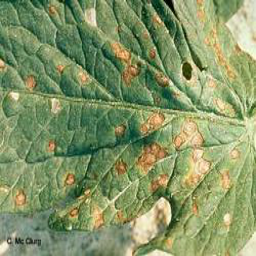

In [20]:
resized_im

In [21]:
resized_im.save("septoria_tomato_l1-250x188.jpg")

In [22]:
# http://blogs.cornell.edu/livegpath/gallery/tomato/tomato-septoria-leaf-spot/

In [23]:
! curl -O http://www.hort.cornell.edu/livegpath/images/septoria_tom_seedlings1x1200.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  312k  100  312k    0     0   444k      0 --:--:-- --:--:-- --:--:--  443k


In [24]:
im = Image.open("septoria_tom_seedlings1x1200.jpg")
resized_im = im.resize((256,256))
resized_im.save("septoria_tom_seedlings1x1200.jpg")

In [25]:
# https://apps.extension.umn.edu/garden/diagnose/plant/vegetable/tomato/leavesspots.html

In [26]:
! curl -O https://apps.extension.umn.edu/garden/diagnose/plant/images/tomato/diseases/septoria2_600px.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55849  100 55849    0     0  85921      0 --:--:-- --:--:-- --:--:-- 85789


In [27]:
im = Image.open("septoria2_600px.jpg")
resized_im = im.resize((256,256))
resized_im.save("septoria2_600px.jpg")

In [28]:
! curl -O https://apps.extension.umn.edu/garden/diagnose/plant/images/tomato/diseases/earlyblight2_600px.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k


In [29]:
im = Image.open("earlyblight2_600px.jpg")
resized_im = im.resize((256,256))
resized_im.save("earlyblight2_600px.jpg")

In [31]:
! curl -O https://extension.umd.edu/sites/extension.umd.edu/files/_images/programs/grow_it_eat_it/diseases/Septoria/20090710-Septoria%20leaf%20spot%203.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58853  100 58853    0     0  98746      0 --:--:-- --:--:-- --:--:-- 98746


In [32]:
filename = "20090710-Septoria%20leaf%20spot%203.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)

In [33]:
# https://www.invasive.org/browse/detail.cfm?imgnum=5503914

In [34]:
! curl -O https://bugwoodcloud.org/images/768x512/5503914.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108k  100  108k    0     0   174k      0 --:--:-- --:--:-- --:--:--  174k


In [35]:
filename = "5503914.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)

In [37]:
! curl -O https://bugwoodcloud.org/images/768x512/5430722.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74119  100 74119    0     0   128k      0 --:--:-- --:--:-- --:--:--  128k


In [38]:
filename = "5430722.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)

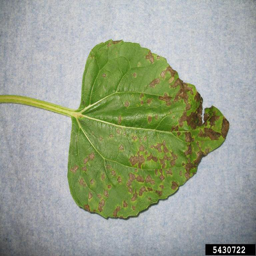

In [39]:
resized_im

In [40]:
! curl -O https://bugwoodcloud.org/images/768x512/5465560.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46820  100 46820    0     0  92347      0 --:--:-- --:--:-- --:--:-- 92347


In [41]:
filename = "5465560.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)

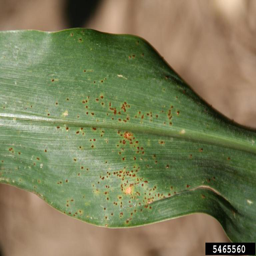

In [44]:
resized_im

In [42]:
! curl -O https://bugwoodcloud.org/images/768x512/1571049.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0   186k      0 --:--:-- --:--:-- --:--:--  186k


In [43]:
filename = "1571049.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)

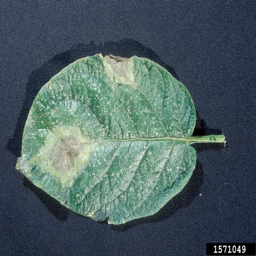

In [44]:
resized_im

In [45]:
! curl -O https://bugwoodcloud.org/images/768x512/5365398.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58052  100 58052    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k


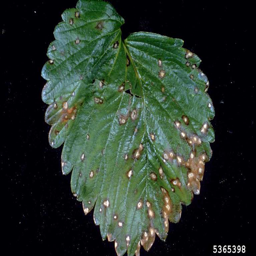

In [46]:
filename = "5365398.jpg"
im = Image.open(filename)
resized_im = im.resize((256,256))
resized_im.save(filename)
resized_im

In [27]:
! curl -O https://extension.umn.edu/sites/extension.umn.edu/files/styles/caption_small/public/septoria-leaf-spot.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38536  100 38536    0     0  79455      0 --:--:-- --:--:-- --:--:-- 79292


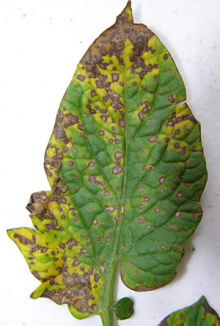

In [31]:
filename = "septoria-leaf-spot.jpg"
image_raw = open(filename, "rb").read()
im = Image.open(BytesIO(image_raw))
im

In [36]:
resized_im.tobytes()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01+\x01+\x00\x00\xff\xed!jPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x17\x1c\x01Z\x00\x03\x1b%G\x1c\x01Z\x00\x03\x1b%G\x1c\x02\x00\x00\x02\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xc7]\x17\xe5t\xb5n\xf5\xdb\xbe9\x94\xc0\xe9y\\8BIM\x04:\x00\x00\x00\x00\x00\xe5\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0bprintOutput\x00\x00\x00\x05\x00\x00\x00\x00PstSbool\x01\x00\x00\x00\x00Inteenum\x00\x00\x00\x00Inte\x00\x00\x00\x00Clrm\x00\x00\x00\x0fprintSixteenBitbool\x00\x00\x00\x00\x0bprinterNameTEXT\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0fprintProofSetupObjc\x00\x00\x00\x0c\x00P\x00r\x00o\x00o\x00f\x00 \x00S\x00e\x00t\x00u\x00p\x00\x00\x00\x00\x00\nproofSetup\x00\x00\x00\x01\x00\x00\x00\x00Bltnenum\x00\x00\x00\x0cbuiltinProof\x00\x00\x00\tproofCMYK\x008BIM\x04;\x00\x00\x00\x00\x02-\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x12printOutputOptions\x00\x00\x00\x17\x00\x00\x00\x00Cptnbool\x00\x00\x00\x00\x00Clbrbool\x00\x00

In [15]:
model = tf.keras.models.load_model("../models/7feacba0-2be0-4761-ba49-854067714f3b/2020-02-08__23_4632/final.h5")

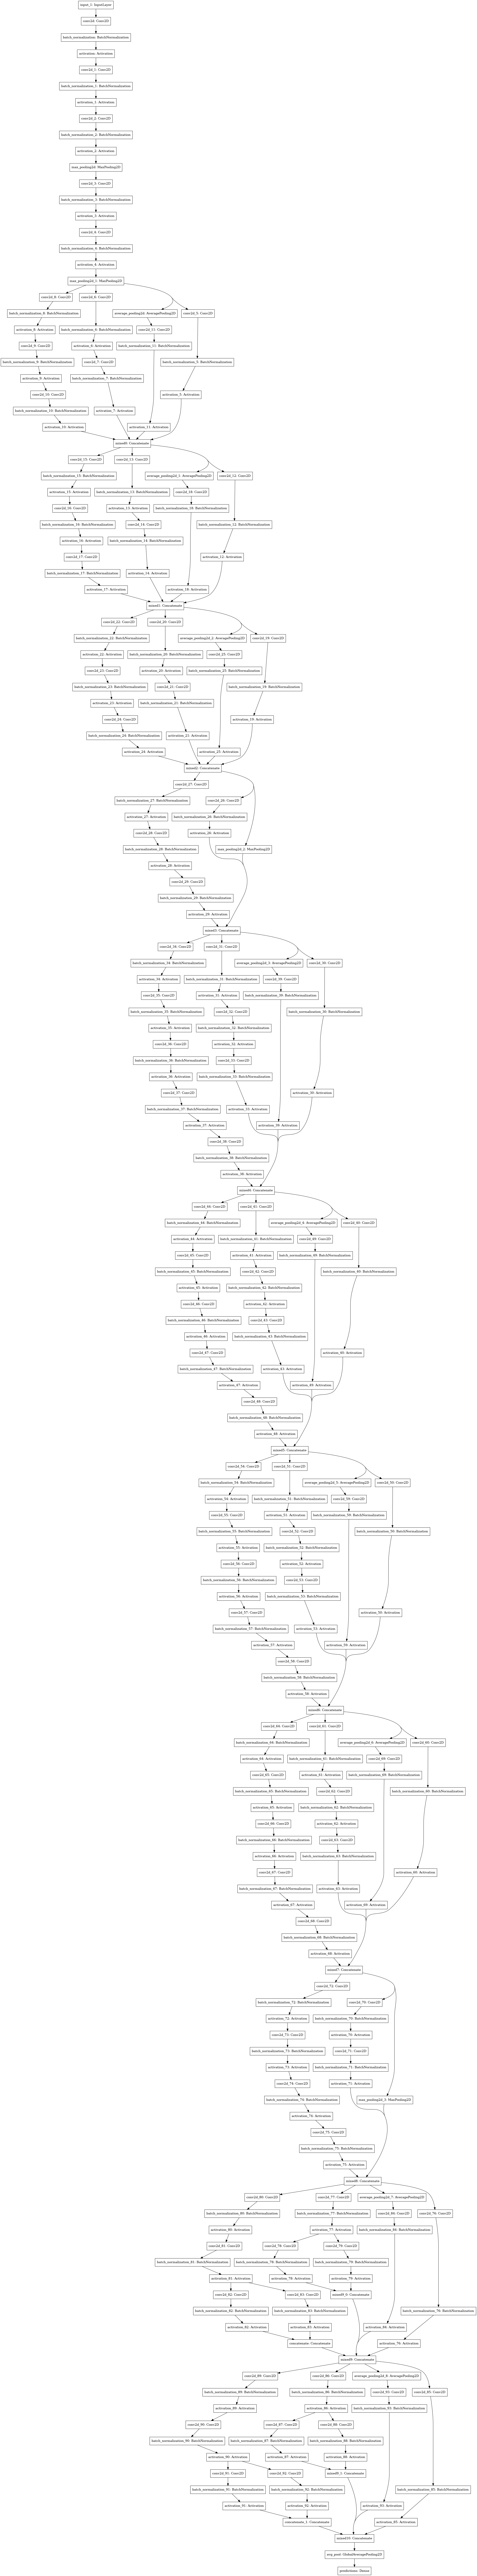

In [19]:
tf.keras.utils.plot_model(
    model,
    to_file='inceptionv3_LR.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

In [20]:
model.weights

[<tf.Variable 'conv2d_95/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-0.04980316,  0.12310564,  0.0600182 , -0.04964734,
           -0.08510838,  0.06450803,  0.1855116 ,  0.07561547,
           -0.16127001,  0.2671842 , -0.14320035, -0.21018831,
            0.0449223 , -0.01436241,  0.04821485, -0.06763506,
           -0.0240185 ,  0.118583  , -0.05246726,  0.14341897,
           -0.14835638, -0.19062841, -0.03743988, -0.01424071,
           -0.00287995, -0.09618097,  0.06699916,  0.01726078,
           -0.1302134 ,  0.15610206,  0.05135074,  0.05661554],
          [-0.06475248,  0.21783035, -0.09218046,  0.14718847,
            0.15146032, -0.11070235,  0.02508665, -0.21429287,
           -0.13189678,  0.04616461, -0.18706106, -0.00125172,
           -0.08214077,  0.05743343,  0.17334226, -0.06391209,
            0.13386713,  0.0293674 ,  0.10478774, -0.17461677,
            0.15197293, -0.09810577,  0.03878222, -0.16911535,
            0.04816145,  0.11508757,  0.

In [21]:
model.summary()

Model: "inceptionv3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________________

In [22]:
import io

In [25]:
resized_im

NameError: name 'resized_im' is not defined